In [1]:
import numpy as np
import octomap
import pclpy
import matplotlib.pyplot as plt
import numpy as np
import bbox
import open3d as o3d
import random
from copy import deepcopy
import pandas as pd
import networkx as nx
import itertools

from scipy.spatial.distance import cdist,euclidean
import time

In [2]:
cloud = pclpy.pcl.PointCloud.PointXYZRGB()
#pclpy.pcl.io.loadPCDFile('treedense1.pcd',cloud)
#pclpy.pcl.io.loadPCDFile('/home/gyk/data/trees_globcen.pcd',cloud)
pclpy.pcl.io.loadPCDFile('/home/gyk/data/treedense1.pcd',cloud)
#pclpy.pcl.io.loadPCDFile('/home/gyk/data/big_env.pcd',cloud)

plist=[]
for point in cloud.points:
    plist.append([point.x,point.y,point.z])
parray= np.asarray(plist)
parray.astype(float)

#parameters
resolution= 1
origin=np.array([18, 13.5,11])#11

#create octree
tree = octomap.OcTree(resolution)
for every in parray: 
    tree.insertPointCloud(np.asarray([every]),np.array([every[0],every[1],origin[2]]))
    
if tree.writeBinary(b"/home/gyk/data/testin4.bt"):
    print("Create octree file.")
else:
    print("Cannot create octree file.")

Create octree file.


In [39]:
print(tree.getMetricSize())

[64. 51. 12.]


In [41]:
def getbbminmax(point,size):
    return point-(size/2),point+(size/2)

def b_cond(bb_min,bb_max,value):
    X_min=bb_min[0]
    Y_min=bb_min[1]
    Z_min=bb_min[2]
    X_max=bb_max[0]
    Y_max=bb_max[1]
    Z_max=bb_max[2]
    X,Y,Z=value[0],value[1],value[2]
    if X_min <= X <= X_max and Y_min <= Y <= Y_max  and Z_min <= Z <= Z_max:
        return True
    return False

def getrandomvoxels(voxeldict,val):
    try:
        a=random.sample(voxeldict,val)
        return a
    except:
        return True

def condition(coords_a,coords_b,size_a,size_b):
    size_cond= (size_a+size_b)/2
    count=0
    for i in range(len(coords_a)):
        if coords_a[i]==coords_b[i]:
            count +=1 
    if abs(coords_a[0]-coords_b[0]) <= size_cond:
            if abs(coords_a[1]-coords_b[1]) <= size_cond:
                    if abs(coords_a[2]-coords_b[2]) <= size_cond:
                        if count==2:
                            return True
    return False
        
        
    
def checkconnection(a,b):
    a_coords=a[:3]
    b_coords=b[:3]
    a_size=1
    b_size=1
    if condition(a_coords,b_coords,a_size,b_size)== True:
        return True
    return False
    
def removedkey(dic, key):
    r = dict(dic)
    del r[key]
    return r

def checking(out,childs):
    for i in out:
        if i not in childs:
            return False
    return True 

def errs(x,y,z,x1,y1,z1,childs):
    fix='x'
    if fix =='x':
        X= np.hstack((x1,x))[np.newaxis].T
        Y= np.hstack((y1,y))[np.newaxis].T
        Z= np.hstack((z,z1))[np.newaxis].T
        print(X,Y,Z)
        out= np.hstack((X,Y,Z))
        if not checking(out,childs):
            return out
        else:
            fix='y'
            print('checking y')
            
    if fix =='y':
        X= np.hstack((x1,x))[np.newaxis].T
        Y= np.hstack((y,y1))[np.newaxis].T
        Z= np.hstack((z1,z))[np.newaxis].T
        out= np.hstack((X,Y,Z))
        if not checking(out,childs):
            return out
        else:
            fix='z'
            print('checking z')
            
    if fix =='z':
        X= np.hstack((x1,x))[np.newaxis].T
        Y= np.hstack((y1,y))[np.newaxis].T
        Z= np.hstack((z,z1))[np.newaxis].T
        out= np.hstack((X,Y,Z))
        return out

def join_nodes(curr, succ, childs):
    distance= np.asarray(abs(curr-succ),dtype='uint8')
    #pat= ['x','y','z']

    x= np.linspace(curr[0]+1,succ[0],num=distance[0])
    y= np.linspace(curr[1]+1,succ[1],num=distance[1])
    z= np.linspace(curr[2]+1,succ[2],num=distance[2])
    x1= np.full((distance[0]), curr[0])
    y1= np.full((distance[1]), curr[1])
    z1= np.full((distance[2]), curr[1])
    print(x,y,z,x1,y1,z1)
    return errs(x,y,z,x1,y1,z1,childs)

def find_neigh(every,data_arr):
    nb=[]
    for j in range(data_arr.shape[0]):
        if checkconnection(data_arr[every],data_arr[j]):
            nb.append(j)
    return nb

def midpoint(p1, p2):
    return np.asarray([(p1[0]+p2[0])/2, (p1[1]+p2[1])/2,(p1[2]+p2[2])/2])
def cal_dist(a, b):
    #print(a,b)
    return  np.linalg.norm(a-b)

def get_distance(a,b):

    a,b= np.asarray([a]),np.asarray([b])
    #print(a,b)
    return cdist(a,b, metric='cityblock')


def save_as_csv(D_graph,file_path,mode,waypts):
    '''
    mode=1 for save data
    mode=2 for saving nodes 
    '''
    if mode==1:
        arr=[]
        for key,vals in D_graph.items():
            for subs,values in vals.items():
                if subs!='nodes':
                    for i in values:
                        arr.append(i)
        arr= np.asarray(arr)

        one_ar= np.ones(arr.shape[0])

        fine_arr= np.hstack((arr,one_ar[np.newaxis].T))

        dfempty = pd.DataFrame({'Column1': fine_arr[:, 0], 'Column2': fine_arr[:, 1],
                                'Column3': fine_arr[:, 2],'Column4': fine_arr[:, 3]})
        dfempty.to_csv(file_path)
        
        return True
    
    if mode==2:
        arr=[]
        for key,vals in D_graph.items():
            for subs,values in vals.items():
                if subs=='nodes':
                    for i in values:
                        arr.append(i)
        arr= np.asarray(arr)

        one_ar= np.ones(arr.shape[0])

        fine_arr= np.hstack((arr,one_ar[np.newaxis].T))

        dfempty = pd.DataFrame({'Column1': fine_arr[:, 0], 'Column2': fine_arr[:, 1],
                                'Column3': fine_arr[:, 2],'Column4': fine_arr[:, 3]})
        dfempty.to_csv(file_path)
        return True
    
    if mode==3:
        arr=np.asarray(waypoints)
        one_ar= np.ones(arr.shape[0])

        fine_arr= np.hstack((arr,one_ar[np.newaxis].T))

        dfempty = pd.DataFrame({'Column1': fine_arr[:, 0], 'Column2': fine_arr[:, 1],
                                'Column3': fine_arr[:, 2],'Column4': fine_arr[:, 3]})
        dfempty.to_csv(file_path)
        return True
    
    return False


def euc_dis(a,b):
    a,b= np.asarray([a]),np.asarray([b])
    return euclidean(a,b)

def find_path_lenth(waypts):
    length=0
    for i in range(len(waypts)-1):
        length += euc_dis(waypts[i],waypts[i+1])
    return length

In [42]:

occupied,empty = tree.extractPointCloud()
#print(tree.getMetricSize())
start_point= [0.0,0.0,0.0]
max_size= [64., 51., 12.] #[64,51,10]#[22., 46., 36.] 
centers_arr=np.asarray([np.arange(int(start_point[0]+1),int(max_size[0]),8),
         np.arange(int(start_point[1]+1),int(max_size[1]),8),
         np.arange(int(start_point[2]+1),int(max_size[2]),8)])
center_coords=[]
for x in centers_arr[0]:
    for y in centers_arr[1]:
        for z in centers_arr[2]:
            center_coords.append([x,y,z])  
#print(center_coords)
bbx_arr=np.asarray(center_coords,dtype='double')
# fig = plt.figure(figsize=(20,20))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(bbx_arr[:,0],bbx_arr[:,1],bbx_arr[:,2])
# ax.scatter(occupied[:,0],occupied[:,1],occupied[:,2])
# #ax.scatter(empty[:,0],empty[:,1],empty[:,2])
# ax.set_xlabel('X ')
# ax.set_ylabel('Y ')
# ax.set_zlabel('Z ')
# plt.show()

err=[]
for i in range(len(bbx_arr)):
    try:
        node=tree.search(bbx_arr[i])
        #print(node.getValue())
    except:
        err.append(i)
        #node.childExists(np.asarray(i,dtype='double'))

# for i in err:
#     print('fff',tree.getNodeChild())
# curnode= tree.search(err[1])
# print(curnode.hasChildren())
# for i in tree.begin_tree():
#     if i==curnode:
#         print(i.getOccupancy())
#plotin3d(np.asarray(err))
bbx_arr_cleaned=[]
for i in range(len(bbx_arr)):
    if i not in err:
        bbx_arr_cleaned.append(bbx_arr[i])
bbx_arr_cleaned = np.asarray(bbx_arr_cleaned)
#print(bbx_arr_cleaned.shape)

/home/gyk/anaconda3/envs/rnd/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [43]:
len(empty)

17548

### Get free voxels inside each bounding box 

#### Stucture = dict(0:dict('nodes':[],'(sam_node_1,sam_node_2)':[]))

In [44]:
graph={}
box_size=8
count=0
number=5

# free_nodes=[]
# for i in tree.begin_leafs():
#     if i.getOccupancy()< 0.5:
#         #free_nodes.append({'pos':tuple(i.getCoordinate()),'size':i.getSize()})
#         free_nodes.append(i.getCoordinate())
# empty=np.asarray(free_nodes)
one_ar= np.ones(empty.shape[0])

fine_arr= np.hstack((empty,one_ar[np.newaxis].T))

for idx,every in enumerate(bbx_arr_cleaned):
    bbmin,bbmax= getbbminmax(every,box_size)
    #print(count)
    count=0
    out=[]
    for i in fine_arr:
        if b_cond(bbmin,bbmax,i):
            out.append(i)
    graph[idx]=out

print(graph.keys())      

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111])


In [45]:
stime= time.time()
D_graph={}
und_graph = nx.Graph()
nodes_arr=[]
count=0
no_dic={}
for keys,childs in graph.items():
    #boundingbox idx (keys)
    #print(keys,childs)
    length= int(len(childs)*0.14)
#     if length==1:
#         print(childs)
#         D_graph[keys]=childs
#     else:
    print(len(childs))
    try:
        data_arr=np.asarray(childs)
        data_arr=data_arr[:,0:3]
        G= nx.DiGraph()
        for every in range(data_arr.shape[0]):
            G.add_node(every)

        for every in range(data_arr.shape[0]):
            nb_vals=find_neigh(every,data_arr)
            for j in nb_vals:
                G.add_edge(every,j)

        while True:
            loc_path={}
            nodes=getrandomvoxels(range(0,len(childs)),3)
            loc_path['nodes']=[data_arr[x] for x in range(0,len(childs)) if x in nodes]
            for subset in itertools.combinations(nodes,2):
                try:
                    path=list(nx.shortest_path(G,subset[0],subset[1]))
                    node_a=list(data_arr[subset[0]])
                    node_b=list(data_arr[subset[1]])
                    if node_a not in nodes_arr:
                        nodes_arr.append(node_a)
                    if node_b not in nodes_arr:
                        nodes_arr.append(node_b)
                    idx_a,idx_b= nodes_arr.index(node_a),nodes_arr.index(node_b)
                    #print(idx_a)
                    pathlist=[]
                    for i in path:
                        pathlist.append(data_arr[i])
                    loc_path[(idx_a,idx_b)]=pathlist
                    #und_graph.add_edge(idx_a,idx_b,weight=cdist([node_a],[node_b], metric='cityblock'))
                    comb_status= True
                except:
                    comb_status= False

            if comb_status:
                break

    #     loc_path={}
    #     nodes=getrandomvoxels(range(0,len(childs)),3)
    #     loc_path['nodes']=[data_arr[x] for x in range(0,len(childs)) if x in nodes]
    #     for subset in itertools.combinations(nodes,2):
    #         try:
    #             path=list(nx.shortest_path(G,subset[0],subset[1]))
    #             pathlist=[]
    #             for i in path:
    #                 pathlist.append(data_arr[i])
    #             loc_path[subset]=pathlist
    #             comb_status= True
    #         except:
    #             print(subset)

    #     print('done')   
        D_graph[keys]= loc_path
    except:
        continue
#print(D_graph)
#########################################################################################
centers_arr= {}
for i in range(bbx_arr_cleaned.shape[0]):
    for j in range(bbx_arr_cleaned.shape[0]):
        dist=cal_dist(bbx_arr_cleaned[i,:],bbx_arr_cleaned[j,:])
        #print(dist)
        if i!=j and dist==8:
            centers_arr[i,j]= midpoint(bbx_arr_cleaned[i,:],bbx_arr_cleaned[j,:])
result = {}
temp_arr= deepcopy(centers_arr)

for key,value in temp_arr.items():
        temp_arr[key] = list(value)
for key,value in temp_arr.items():
    if value not in result.values():
        result[key] = value
# print(result)
##########################################################################################
graph={}
box_size=8
count=0
number=5

one_ar= np.ones(empty.shape[0])

fine_arr= np.hstack((empty,one_ar[np.newaxis].T))

for idx,every in result.items():
    bbmin,bbmax= getbbminmax(np.asarray(every),box_size)
    out=[]
    for i in empty:
        if b_cond(bbmin,bbmax,i):
            out.append(list(i))
    graph[idx]=out

#print(graph) 
###########################################################################################
arr=[]

for key,vals in D_graph.items():
    for subs,values in vals.items():
        if subs=='nodes':
            for i in values:
                arr.append(list(i))
#arr= np.asarray(arr)
#print(arr)

for key,vals in graph.items():
    comm_nodes=[]
    for i in arr:
        if i in vals:
            comm_nodes.append(vals.index(i))
    
    data_arr=np.asarray(vals)
    G= nx.DiGraph()
    for every in range(data_arr.shape[0]):
        G.add_node(every)
       
    for every in range(data_arr.shape[0]):
        nb_vals=find_neigh(every,data_arr)
        for j in nb_vals:
            G.add_edge(every,j)
    
    loc_path={}
    nodes=comm_nodes
    #loc_path['nodes']=[data_arr[x] for x in range(0,len(childs)) if x in nodes]
    for subset in itertools.combinations(nodes,2):
        try:
            path=list(nx.shortest_path(G,subset[0],subset[1]))
            node_a=list(data_arr[subset[0]])
            node_b=list(data_arr[subset[1]])
            idx_a,idx_b= nodes_arr.index(node_a),nodes_arr.index(node_b)
            pathlist=[]
            for i in path:
                pathlist.append(data_arr[i])
            loc_path[(idx_a,idx_b)]=pathlist
        except:
            pass
    D_graph[key]= loc_path
time_learn= np.asarray(time.time()-stime)
print(time_learn)

0
0
32
109
65
280
10
283
0
236
0
184
0
31
6
15
143
400
108
453
15
439
0
389
0
313
0
88
94
216
166
447
102
462
19
472
0
388
0
338
0
150
149
280
171
449
100
443
23
451
0
416
0
343
0
206
130
238
193
451
125
455
36
453
0
416
0
361
0
71
58
103
214
449
154
448
53
451
2
450
0
156
0
0
0
0
175
348
171
448
117
451
21
228
0
7
0
0
0
0
75
139
216
458
96
239
1
8
0
0
0
0
59.41425395011902


In [22]:
for i in empty:
    if int(i[0])==23 and int(i[1])==21 and int(i[2])==10:
        print(i)
print(empty)

[[-17.  -13.   -3. ]
 [-17.  -13.   -2. ]
 [-16.  -13.   -2. ]
 ...
 [ 17.5  12.5  11.5]
 [ 17.5  13.5  10.5]
 [ 17.5  13.5  11.5]]


In [50]:
print(empty)

[[ 8.  8.  3.]
 [ 8.  8.  4.]
 [ 8.  8.  5.]
 ...
 [49. 33. 10.]
 [49. 33. 11.]
 [49. 33. 12.]]


## Visualize Local paths

In [13]:
save_as_csv(D_graph,'/home/gyk/data/mypaths_empty_map2.csv',2,0)

True

## Visualize nodes 

In [14]:
save_as_csv(D_graph,'/home/gyk/data/mypaths_nodes_map2.csv',1,0)

True

## Create Graph and find path  PRM

In [46]:
und_graph = nx.Graph()
for key,vals in D_graph.items():
    for subs,values in vals.items():
        if subs =='nodes':
            pass
        else:
#             print(subs[0])
            und_graph.add_edge(subs[0],subs[1],weight=get_distance(nodes_arr[subs[0]],nodes_arr[subs[1]]))
df_out= pd.DataFrame(columns=['sx','sy','sz','ex','ey','ez','time_learn','time_query','pathlength'])

# nx.draw(und_graph)
# plt.show()
# node_names=list(und_graph.nodes())
# print(node_names)

## A*

In [ ]:
stime= time.time()
G= nx.Graph()
# for every in range(empty.shape[0]):
#     G.add_node(every)
count=0
for every in range(empty.shape[0]):
    count += 1
    nb_vals=find_neigh(every,empty)
    if every%100:
#         print('computing')
        pass
    for j in nb_vals:
        G.add_edge(every,j)
print(time.time()-stime)

# Evaluation PRM

In [51]:
for i in range(1):
    gr_arr=[]
    vals_dic={}
    for key,vals in D_graph.items():
        for subs,values in vals.items():
            if subs=='nodes':
                for i in values:
                    gr_arr.append(i)

    for key,vals in D_graph.items():
        for subs,values in vals.items():
            if subs!='nodes':
                vals_dic[subs]=values

    stime= time.time()
    und_graph = nx.Graph()
    for key,vals in D_graph.items():
        for subs,values in vals.items():
            if subs =='nodes':
                pass
            else:
    #             print(subs[0])
                und_graph.add_edge(subs[0],subs[1],weight=get_distance(nodes_arr[subs[0]],nodes_arr[subs[1]]))

    start,stop= random.sample(nodes_arr,2)
    start= [8,8,3]
    stop= [49,33,10]

#     start= [1.49999994 ,1.49999994, 2.09999996]
#     stop= [24.29999953508377, 21.900000393390656, 8.699999868869781]
    dis_start=[]
    dis_stop=[]
    count=0
    #print(nodes_arr)
    while True:
        try:
            for i in nodes_arr:
                dis_start.append(euc_dis(start,i))
                dis_stop.append(euc_dis(stop,i))
            dis_s= deepcopy(dis_start)
            dis_e= deepcopy(dis_stop)
            dis_start.sort(),dis_stop.sort()

            begin= dis_s.index(dis_start[count])
            end=dis_e.index(dis_stop[count+1])

            print(nodes_arr[begin],nodes_arr[end])
            #print(und_graph.nodes)
            shor_path=nx.shortest_path(und_graph,begin,end)
            comb_status= True
        except:
            count+=1
            #print(count)
            if count>1000:
                comb_status= True
            comb_status= False

        if comb_status:
            break


    waypoints=[]
    for elem in range(0,len(shor_path)-1):
        try:
            temp=vals_dic[(shor_path[elem],shor_path[elem+1])]
            for i in temp:
                waypoints.append(i)
        except:
            temp=vals_dic[(shor_path[elem+1],shor_path[elem])]
            for i in temp:
                waypoints.append(i)
    # print(waypoints)
    time_query= np.asarray(time.time()-stime)
    print(time_query)
    pathlength=np.asarray(find_path_lenth(waypoints))

    pos=(np.hstack((nodes_arr[begin],nodes_arr[end],time_learn,time_query,pathlength)))
    #print(pos)
    df_temp=pd.DataFrame([pos],columns=['sx','sy','sz','ex','ey','ez','time_learn','time_query','pathlength'])
    df_out= df_out.append(df_temp,ignore_index=True)

waypoints.append([23.5 , 21.5 , 10.5])
waypoints=np.asarray(waypoints)

[8.5, 6.5, 4.5] [47.5, 32.5, 9.5]
0.033000946044921875


In [52]:
print(df_out.head())
df_out.to_csv('/home/gyk/data/prm/evaluationubigmap.csv')

    sx    sy   sz    ex    ey   ez  time_learn  time_query  pathlength
0  4.0  10.0  3.0   4.0  12.0  4.0   59.414254    0.042303    3.000000
1  8.5   6.5  4.5  47.5  32.5  9.5   59.414254    0.033001  128.468152


In [53]:
save_as_csv(4,'/home/gyk/data/prm/mypaths_path_prm_{}.csv'.format(6),3,waypoints)

True

# Evaluation A*

In [ ]:
empty_l=[]
for i in empty:
    empty_l.append(list(i))
start=empty_l.index([2.5, 0.5, 2.5])
stop=empty_l.index([26.5, 23.5, 7.5])
shor_path=nx.shortest_path(G,start,stop)
waypoints=[]
for i in list(shor_path):
    waypoints.append(empty_l[i])

In [ ]:
save_as_csv(D_graph,'/home/gyk/data/mypaths_path_astar.csv',3,waypoints)

In [ ]:
print(find_path_lenth(waypoints))

In [ ]:
chec=np.asarray(waypoints)

In [ ]:
chec[0]

In [ ]:
free_nodes=[]
for i in tree.begin_leafs():
    if i.getOccupancy()< 0.5:
        #free_nodes.append({'pos':tuple(i.getCoordinate()),'size':i.getSize()})
        free_nodes.append(i.getCoordinate())
            

In [ ]:
recur_nodes=[]
for j in range(len(free_nodes)):
    ptr=free_nodes[j]
    bmin,bmax= getbbminmax(np.asarray(ptr['pos']),ptr['size'])
    if ptr['size']== 4:
        recur_nodes.append(ptr)
    for k in free_nodes:
        current_pnt= k['pos']
        if b_cond(bmin,bmax,current_pnt) and current_pnt != ptr['pos']:
            pass
        else:
            pass
            
    
waypoints=[]
for i in free_nodes:
    waypoints.append(list(i['pos']))

print(waypoints)

In [14]:
#save_as_csv('NaN','/home/gyk/data/mypaths_path_check.csv',3,waypoints)

dfstar=pd.read_csv('/home/gyk/data/mypaths_path_astar_sparse.csv')
waypoints_star= np.asarray([dfstar['Column1'],dfstar['Column2'],dfstar['Column3']])
waypoints_star=waypoints_star.T

dfway=pd.read_csv('/home/gyk/data/prm/mypaths_path_prm.csv')
waypoints= np.asarray([dfway['Column1'],dfway['Column2'],dfway['Column3']])
waypoints=waypoints.T

dfrev=pd.read_csv('/home/gyk/data/reversed.csv')
reversed_points= waypoints[:12,:]
reversed_points= np.flip(reversed_points,axis=0)
# waypoints_star= np.asarray([dfstar['Column1'],dfstar['Column2'],dfstar['Column3']])
# waypoints_star=waypoints_star.T
#waypoints = np.asarray(np.unique(waypoints,axis=1))
print(reversed_points)

ltstar=np.array([[2.5,1.5,2.5],[3,1,3],[3,3,3],[22,14,6],[21,17,7],[22.5,23.5,7.5],[23.5,21.5,10.5]])
orgend=np.array([[2.5,1.5,2.5],[23.5,21.5,10.5]])

[[3.5 3.5 2.5]
 [3.5 2.5 2.5]
 [3.5 1.5 2.5]
 [2.5 1.5 2.5]
 [1.5 1.5 2.5]
 [1.5 1.5 3.5]
 [1.5 1.5 4.5]
 [1.5 1.5 4.5]
 [1.5 1.5 3.5]
 [0.5 1.5 3.5]
 [0.5 0.5 3.5]
 [0.5 0.5 2.5]]


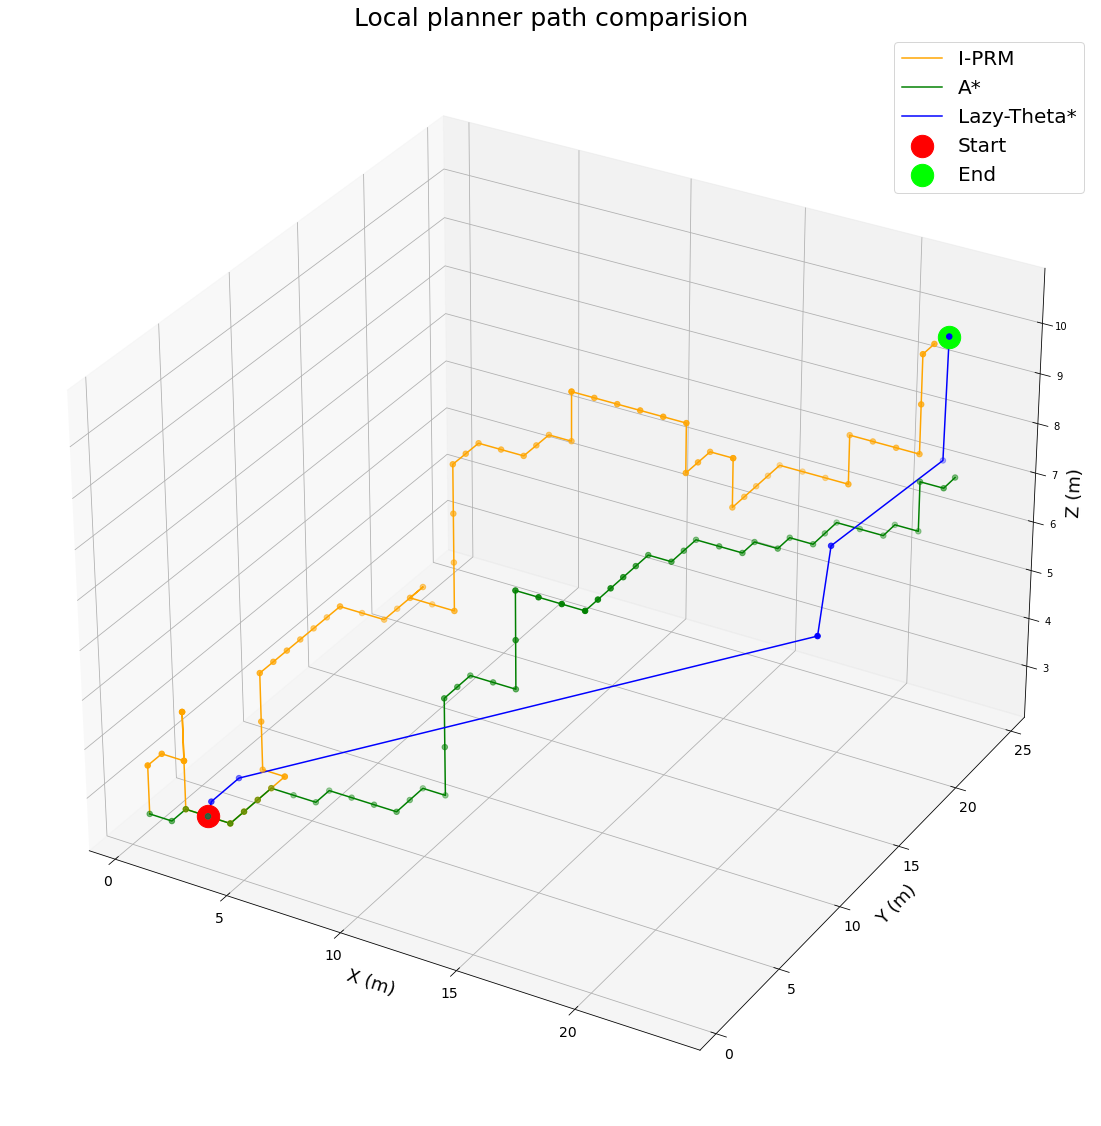

NameError: name 'save_as_csv' is not defined

In [15]:
import matplotlib as mpl


# x= list(occupied[:,0])
# y=list(occupied[:,1])
# z=list(occupied[:,2])
#print(x)
#waypoints=np.unique(waypoints)
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')

#ax.scatter(bbx_arr[:,0],bbx_arr[:,1],bbx_arr[:,2])
#ax.scatter(parray[:,0],parray[:,1],parray[:,2],depthshade=False)
#ax.scatter(occupied[:,0],occupied[:,1],occupied[:,2],depthshade=False,s=100)
#ax.voxels(x,y,z,filled=[1,1,1])
#ax.scatter(empty[:,0],empty[:,1],empty[:,2])
ax.scatter(orgend[0,0],orgend[0,1],orgend[0,2], c='r',s=500,label='Start')
ax.scatter(orgend[1,0],orgend[1,1],orgend[1,2], c='lime',s=500,label='End')
ax.scatter(waypoints[1:,0],waypoints[1:,1],waypoints[1:,2], c='orange',s=30)
ax.scatter(ltstar[:,0],ltstar[:,1],ltstar[:,2], c='b',s=30)
ax.scatter(waypoints_star[:,0],waypoints_star[:,1],waypoints_star[:,2], c='g',s=30)
ax.plot(waypoints[:,0],waypoints[:,1],waypoints[:,2],label='I-PRM', color='orange')
#ax.plot(waypoints[12:,0],waypoints[12:,1],waypoints[12:,2],label='I-PRM', color='orange')
#ax.plot(reversed_points[:,0],reversed_points[:,1],reversed_points[:,2], color='orange')
ax.plot(waypoints_star[:,0],waypoints_star[:,1],waypoints_star[:,2],label='A*', color='g')
ax.plot(ltstar[:,0],ltstar[:,1],ltstar[:,2],label='Lazy-Theta*', color='b')

mpl.rcParams['legend.fontsize'] = 20
ax.legend()
ax.set_xlabel('X (m)',fontdict={'fontsize': 18,'fontweight':2})
ax.set_ylabel('Y (m)',fontdict={'fontsize': 18,'fontweight':2})
ax.set_zlabel('Z (m)',fontdict={'fontsize': 18,'fontweight':2})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_title('Local planner path comparision',fontdict={'fontsize': 25,'fontweight':2})
plt.show()

save_as_csv('NaN','/home/gyk/data/waypoints_prms.csv',3,waypoints)
save_as_csv('NaN','/home/gyk/data/reversed.csv',3,reversed_points)

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.1        0.1        0.1        ... 0.1        0.1        0.1       ]
  [0.09659258 0.09659258 0.09659258 ... 0.09659258 0.09659258 0.09659258]
  [0.08660254 0.08660254 0.08660254 ... 0.08660254 0.08660254 0.08660254]
  ...
  [0.08660254 0.08660254 0.08660254 ... 0.08660254 0.08660254 0.08660254]
  [0.09659258 0.09659258 0.09659258 ... 0.09659258 0.09659258 0.09659258]
  [0.1        0.1        0.1        ... 0.1        0.1        0.1       ]]

 [[0.2        0.2        0.2        ... 0.2        0.2        0.2       ]
  [0.19318517 0.193185

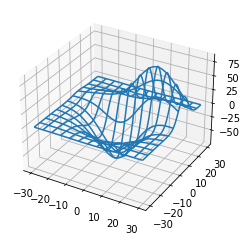

In [234]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Grab some test data.

# Plot a basic wireframe.
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

plt.show()

In [16]:
waypoints

array([[ 0.5,  0.5,  2.5],
       [ 0.5,  0.5,  3.5],
       [ 0.5,  1.5,  3.5],
       [ 1.5,  1.5,  3.5],
       [ 1.5,  1.5,  4.5],
       [ 1.5,  1.5,  4.5],
       [ 1.5,  1.5,  3.5],
       [ 1.5,  1.5,  2.5],
       [ 2.5,  1.5,  2.5],
       [ 3.5,  1.5,  2.5],
       [ 3.5,  2.5,  2.5],
       [ 3.5,  3.5,  2.5],
       [ 3.5,  4.5,  2.5],
       [ 3.5,  5.5,  2.5],
       [ 3.5,  5.5,  2.5],
       [ 2.5,  5.5,  2.5],
       [ 2.5,  5.5,  3.5],
       [ 2.5,  5.5,  4.5],
       [ 2.5,  6.5,  4.5],
       [ 2.5,  7.5,  4.5],
       [ 2.5,  8.5,  4.5],
       [ 2.5,  9.5,  4.5],
       [ 2.5, 10.5,  4.5],
       [ 2.5, 11.5,  4.5],
       [ 2.5, 11.5,  4.5],
       [ 3.5, 11.5,  4.5],
       [ 4.5, 11.5,  4.5],
       [ 4.5, 12.5,  4.5],
       [ 4.5, 13.5,  4.5],
       [ 4.5, 14.5,  4.5],
       [ 4.5, 14.5,  4.5],
       [ 4.5, 13.5,  4.5],
       [ 5.5, 13.5,  4.5],
       [ 6.5, 13.5,  4.5],
       [ 6.5, 13.5,  4.5],
       [ 6.5, 13.5,  5.5],
       [ 6.5, 13.5,  6.5],
 

In [21]:

count=0
for i in waypoints:
    for j in waypoints:
        if tuple(i)==tuple(j):
            count+=1
            if count==2:
                print(i,j)
    count=0

[8.5 4.5 4.5] [8.5 4.5 4.5]
[8.5 4.5 4.5] [8.5 4.5 4.5]
[9.5 2.5 5.5] [9.5 2.5 5.5]
[10.5  2.5  5.5] [10.5  2.5  5.5]
[11.5  2.5  5.5] [11.5  2.5  5.5]
[12.5  2.5  5.5] [12.5  2.5  5.5]
[12.5  2.5  5.5] [12.5  2.5  5.5]
[11.5  2.5  5.5] [11.5  2.5  5.5]
[10.5  2.5  5.5] [10.5  2.5  5.5]
[9.5 2.5 5.5] [9.5 2.5 5.5]
[9.5 7.5 9.5] [9.5 7.5 9.5]
[9.5 7.5 9.5] [9.5 7.5 9.5]
[14.5  9.5  6.5] [14.5  9.5  6.5]
[14.5  9.5  6.5] [14.5  9.5  6.5]
[13.5 15.5  6.5] [13.5 15.5  6.5]
[13.5 15.5  6.5] [13.5 15.5  6.5]
[17.5 19.5  8.5] [17.5 19.5  8.5]
[17.5 19.5  8.5] [17.5 19.5  8.5]
[26.5 21.5  4.5] [26.5 21.5  4.5]
[26.5 21.5  4.5] [26.5 21.5  4.5]
[21.5 23.5  6.5] [21.5 23.5  6.5]
[21.5 24.5  6.5] [21.5 24.5  6.5]
[21.5 25.5  6.5] [21.5 25.5  6.5]
[21.5 25.5  6.5] [21.5 25.5  6.5]
[21.5 24.5  6.5] [21.5 24.5  6.5]
[21.5 23.5  6.5] [21.5 23.5  6.5]


In [200]:
new_array = [tuple(row) for row in waypoints]
uniques = np.unique(new_array,axis=1)

In [217]:
pts_way=[]
for i in range(waypoints.shape[0]):
    try:
        dist=euc_dis(waypoints[i],waypoints[i+1])
    except:
        pass
    if dist>1:
        pts_way.append(waypoints[i+1])
        print(waypoints[i+1])
        pass



[25.5 18.5  4.5]
[25.5 18.5  4.5]


In [202]:
#waypoints= np.delete(waypoints,46,axis=0)

In [31]:
new_l=[]
for i in waypoints:
    new_l.append(tuple(i))

In [204]:
new_k=[]
for i in pts_way:
    new_k.append(tuple(i))

In [33]:
new_l.index(tuple([21.5, 24.5,  6.5]))
waypoints=np.delete(waypoints,[90,91,92,93,94],axis=0)

In [206]:
new_l.remove(new_k[1])

In [207]:
waypoints= np.asarray(new_l)

In [161]:
waypoints=np.delete(waypoints,[4,5,6,7,8,9,10],axis=0)

In [140]:
testing=[path[0]]
for i in range(1,len(path)-1):
    abp= angle_btw_paths([path[i-1],path[i]],[path[i],path[i+1]])
    print(type(str(abp)))
    if abp == "nan":
        print("sucess")
        pass
    else:
        testing.append(path[i])
testing.append(path[-1])



<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

/home/gyk/anaconda3/envs/rnd/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [34]:
waypoints=np.asarray(testing)

NameError: name 'testing' is not defined

In [35]:
print(waypoints)

[[ 2.5  0.5  2.5]
 [ 2.5  1.5  2.5]
 [ 3.5  1.5  2.5]
 [ 4.5  1.5  2.5]
 [ 5.5  1.5  2.5]
 [ 6.5  1.5  2.5]
 [ 6.5  1.5  2.5]
 [ 6.5  1.5  3.5]
 [ 6.5  2.5  3.5]
 [ 6.5  3.5  3.5]
 [ 7.5  3.5  3.5]
 [ 7.5  4.5  3.5]
 [ 7.5  4.5  4.5]
 [ 7.5  4.5  5.5]
 [ 8.5  4.5  5.5]
 [ 9.5  4.5  5.5]
 [ 9.5  4.5  5.5]
 [ 9.5  4.5  6.5]
 [ 9.5  4.5  7.5]
 [ 9.5  4.5  8.5]
 [ 9.5  4.5  9.5]
 [ 9.5  4.5 10.5]
 [ 9.5  5.5 10.5]
 [ 9.5  6.5 10.5]
 [10.5  6.5 10.5]
 [11.5  6.5 10.5]
 [11.5  6.5 10.5]
 [11.5  6.5 11.5]
 [11.5  7.5 11.5]
 [12.5  7.5 11.5]
 [12.5  8.5 11.5]
 [12.5  9.5 11.5]
 [13.5  9.5 11.5]
 [13.5  9.5 11.5]
 [13.5  9.5 10.5]
 [13.5  9.5  9.5]
 [13.5  9.5  8.5]
 [13.5  9.5  7.5]
 [13.5 10.5  7.5]
 [13.5 11.5  7.5]
 [13.5 12.5  7.5]
 [13.5 13.5  7.5]
 [14.5 13.5  7.5]
 [15.5 13.5  7.5]
 [16.5 13.5  7.5]
 [17.5 13.5  7.5]
 [23.5 21.5 10.5]]


## PATH Smoothness

In [34]:
path= ltstar

In [35]:
def angle_btw_paths(A,B):
    vec1= A[1]-A[0]
    vec2= B[1]-B[0]
    numerator= np.dot(vec1,vec2)
    norm_A,norm_B= np.linalg.norm(vec1),np.linalg.norm(vec2)
    denom= norm_A*norm_B
    p_sol=np.arccos(numerator/denom)
    #print(type(p_sol))
    return np.rad2deg(p_sol)
    #print(np.rad2deg(p_sol))

In [36]:
smoothness=[]
for i in range(1,len(path)-1):
    abp= angle_btw_paths([path[i-1],path[i]],[path[i],path[i+1]])
    if str(abp) != "nan" and abp!= 0:
        smoothness.append(abp)
max_smoothness= max(smoothness)
max_smoothness

125.26438968275465

In [32]:
wavg=0
for i in smoothness:
    wavg+= (len(smoothness))*i

weits= wavg/(len(smoothness)*360)
print(weits)

1.1366104341006653


In [37]:
smoothness1=[]
for i in smoothness:
    j=i
    if i >90:
        j= i-90
    smoothness1.append(j)
    wavg=0
for i in smoothness1:
    wavg+= len(smoothness1)*i

weits= wavg/len(smoothness1)
print(weits)

229.17975627623952


In [33]:
smoothness1

[90.0,
 90.0,
 90.0,
 90.0,
 90.0,
 90.0,
 90.0,
 90.0,
 90.0,
 90.0,
 90.0,
 90.0,
 90.0,
 90.0,
 54.92167035403158]

In [38]:
np.mean(smoothness1)

45.835951255247906

## clearence 

In [101]:
datapts=ltstar
dist=[]
for i in parray:
    for j in datapts:
        dist.append(euc_dis(i,j))
min(dist)

1.1070949081603187